<a href="https://colab.research.google.com/github/tocom242242/simple_fx_predict_app/blob/master/predict_fx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install oandapyV20
!pip install schedule

     |████████████████████████████████| 61kB 3.9MB/s 
  Created wheel for oandapyV20: filename=oandapyV20-0.6.3-cp36-none-any.whl size=69742 sha256=5aeafd65bdd4c0d82adc0ce30fa4a6ec801966f17634d3d5dcbbbf72aac5aa45
  Stored in directory: /root/.cache/pip/wheels/2c/b0/cd/49054320a6cc51db0ff4f1ee15d8840375f16cef57b81ebfc0
Successfully built oandapyV20


In [ ]:
ACCESS_TOKEN = "********************************************"  # あなたのOANDA API のアクセストークン
COUNT = 5000        # 一度に取得するデータ数(max:5000)
COUNT_TIMES = 1         # count * COUNT_TIMES 分データを取得
GRANULARITY = "M5"   # 足の種類。今回は５分足
INSTRUMENT = "USD_JPY"    # USD/JPY
INPUT_LEN = 10            # 入力の長さ。現時点から10足前までのデータを入力とする。
EPOCHS = 100              # ニューラルネットワークの学習EPOCH
BATCH_SIZE = 32           # ニューラルネットワークのバッチサイズ
PREDICT_INTERVAL = 1     # 予測の更新頻度 (分)

# 学習結果のモデルの保存先
MODEL_PATH = "/content/drive/My Drive/simple_fx_predict_app/models/model.json"
WEIGHTS_PATH = "/content/drive/My Drive/simple_fx_predict_app/models/weights.h5"


[[105.462]
 [105.517]
 [105.506]
 ...
 [106.078]
 [106.099]
 [106.114]]


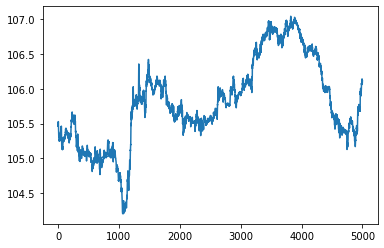

In [ ]:
from oandapyV20 import API
import oandapyV20.endpoints.instruments as instruments
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# OANDA APIにアクセスする
api = API(access_token=ACCESS_TOKEN, environment="practice")

def get_prices(granularity, count, count_times):
    """
        終わり値を取得する
    """
    params = {
        "granularity": granularity,
        "count": count,
        "price": "B",
    }

    candles = None
    for i in range(count_times):
        instruments_candles = instruments.InstrumentsCandles(
            instrument=INSTRUMENT, params=params)
        # OANDA APIにリクエスト 
        api.request(instruments_candles)
        response = instruments_candles.response
        new_candles = pd.DataFrame(response["candles"])
        params["to"] = new_candles["time"].iloc[0]
        # 取得したデータをつなげる 
        candles = pd.concat([new_candles, candles])

    # 終値だけを抽出する
    prices = np.array([x["c"] for x in candles["bid"].values])
    prices = prices.astype(np.float64)
    prices = prices.reshape(-1, 1)

    return prices 


    
prices = get_prices(GRANULARITY, COUNT, COUNT_TIMES)
print(prices)

# データのプロット
fig, ax = plt.subplots()
x = np.arange(len(prices))
ax.plot(x, prices)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# データの取得
prices = get_prices(GRANULARITY, COUNT, COUNT_TIMES)

# データの正規化0〜１の間の数値に
sc = MinMaxScaler(feature_range=(0, 1))
prices = sc.fit_transform(prices)

def create_data_for_model(prices):
    """
        入力 x=[x1,x2,,,] -> 出力 y
        といった形で学習・テスト用のデータの作成
    """

    X, Y = [], []
    prices_len = len(prices)
    for i, _ in enumerate(prices):
        if (i + INPUT_LEN + 1 >= prices_len):
            break
        X.append(prices[i:i + INPUT_LEN])
        Y.append(prices[i + INPUT_LEN + 1])

    X = np.array(X)
    Y = np.array(Y)

    # 学習用・テスト用に分割
    split_index = int(len(prices) * 0.7)
    X_train = X[:split_index]
    Y_train = Y[:split_index]
    X_test = X[split_index:]
    Y_test = Y[split_index:]

    return X_train, Y_train, X_test, Y_test

# 学習・テスト用データの作成
X_train, Y_train, X_test, Y_test = create_data_for_model(prices)

# データの確認
print("x:{} => y:{}".format(X_train[0], Y_train[0]))


x:[[0.44342615]
 [0.46281283]
 [0.4589355 ]
 [0.44765597]
 [0.45928798]
 [0.46704265]
 [0.45541065]
 [0.43743391]
 [0.4282693 ]
 [0.40676771]] => y:[0.40148044]


In [ ]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
import json


# モデルの作成
model = Sequential()
model.add(Flatten(input_shape=[INPUT_LEN, 1]))
model.add(Dense(32))
model.add(Activation("relu"))
model.add(Dense(32))
model.add(Activation("relu"))
model.add(Dense(1))
model.add(Activation("linear"))

model.compile(loss="mse",   # 誤差関数
              optimizer="adam",     # 最適化手法
              metrics=['accuracy'])

# モデルの学習
model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS)

# 学習結果の保存
# モデル構造の保存
model_json = model.to_json()
with open(MODEL_PATH, "w") as f:
    json.dump(model_json, f, indent=4)
# モデルの重みの保存
model.save_weights(WEIGHTS_PATH)

# 評価
# 予測値の計算と変換
predicted_y = model.predict(X_test)
predicted_y = sc.inverse_transform(predicted_y)
# 正解データの変換
Y_test = sc.inverse_transform(Y_test)

# 以下結果のプロット
fig, ax = plt.subplots()
# 正解データのプロット
ax.plot(np.arange(len(Y_test)), Y_test, label="real")
# 予測値のプロット
ax.plot(np.arange(len(predicted_y)), predicted_y, label="predicted_value")

# 凡例の表示
ax.legend()

Epoch 1/100
110/110 [==============================] - 0s 1ms/step - loss: 0.0141 - accuracy: 2.8571e-04
Epoch 2/100
110/110 [==============================] - 0s 1ms/step - loss: 2.9827e-04 - accuracy: 2.8571e-04
Epoch 3/100
110/110 [==============================] - 0s 1ms/step - loss: 2.7306e-04 - accuracy: 2.8571e-04
Epoch 4/100
110/110 [==============================] - 0s 1ms/step - loss: 2.5821e-04 - accuracy: 2.8571e-04
Epoch 5/100
110/110 [==============================] - 0s 1ms/step - loss: 2.6336e-04 - accuracy: 2.8571e-04
Epoch 6/100
110/110 [==============================] - 0s 1ms/step - loss: 2.5246e-04 - accuracy: 2.8571e-04
Epoch 7/100
110/110 [==============================] - 0s 1ms/step - loss: 2.4692e-04 - accuracy: 2.8571e-04
Epoch 8/100
110/110 [==============================] - 0s 1ms/step - loss: 2.5106e-04 - accuracy: 2.8571e-04
Epoch 9/100
110/110 [==============================] - 0s 1ms/step - loss: 2.6753e-04 - accuracy: 2.8571e-04
Epoch 10/100
110/110 [=

KeyboardInterrupt: ignored

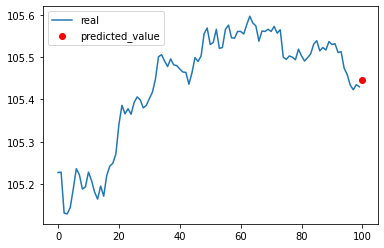

predicted_value: [105.44646]


KeyboardInterrupt: ignored

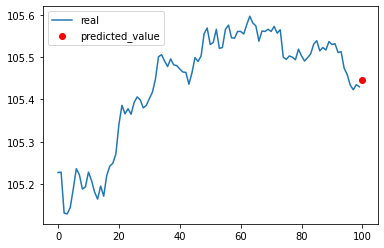

In [ ]:
import schedule
import time
from IPython.display import display, clear_output

# 学習済みモデルの読み込み
model_json = json.load(open(MODEL_PATH))
model = tensorflow.keras.models.model_from_json(model_json)
model.load_weights(WEIGHTS_PATH)

plt.ion()
fig, ax = plt.subplots()


def predict():
    prices = get_prices(GRANULARITY, 100, 1)
    #sc = MinMaxScaler(feature_range=(0, 1))
    prices_for_input = sc.fit_transform(prices)
    # 実際の値と評価値を比較する
    input_value = np.array([prices_for_input[-INPUT_LEN:]])
    # 予想値
    predicted_value = model.predict(input_value)
    predicted_value = sc.inverse_transform(predicted_value)[0]

    x = np.arange(len(prices))
    # 実際の値のプロット
    clear_output(wait=True)
    ax.clear()
    ax.plot(x, prices, label="real")
    ax.scatter([x[-1] + 1], predicted_value,
               color="r", label="predicted_value")
    ax.legend()
    display(fig)
    print("predicted_value:", predicted_value)

# 定期的に実行する時間とメソッドを設定
schedule.every(PREDICT_INTERVAL).minutes.do(predict)

# 定期的に実行
while True:
    schedule.run_pending()
    time.sleep(1)
